In [1]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
import pandas as pd
data = pd.read_csv("GOOG.csv")
#Google Stock Price

#### Olharemos os dados bem por cima

In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512


In [5]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4853,2023-11-29,138.985001,139.669998,136.294998,136.399994,136.399994,21014700
4854,2023-11-30,136.399994,136.960007,132.789993,133.919998,133.919998,29913500
4855,2023-12-01,133.320007,133.500000,132.151993,133.320007,133.320007,24258400
4856,2023-12-04,131.294006,131.449997,129.399994,130.630005,130.630005,24117100
4857,2023-12-05,130.369995,133.539993,129.729996,132.389999,132.389999,19216500


In [6]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
duplicados = data.duplicated()
data[duplicados]

,Date,Open,High,Low,Close,Adj Close,Volume


In [8]:
#decidi usar apenas os 365 dias mais recentes

In [9]:
serie = data["Close"].iloc[-365:].reset_index(drop=True)

In [10]:
# agora que a serie temporal foi carregada e separada corretamente

## Método Box-Jenkins 

#### Identification¶
#### In the identification step, we explore and characterize the data to find the appropriate form of the data so as to be used in the estimation step. First, we will investigate whether the data is stationary or not. If the data is not stationary, we will find which transformation will transfer the data into stationary, and finally, we will identify the order of p and q that are most promising.

#### The tools used in this step are plotting, augmented dicky-fuller test, differencing and other transformation such as log transformation, and ACF and PACF for identifying promising model orders

### Verificar estacionariedade da Serie:

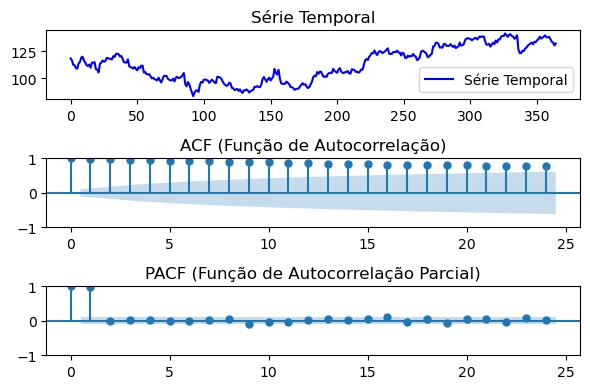

In [11]:


fig, axes = plt.subplots(3, 1, figsize=(6, 4), sharex=False)


axes[0].plot(serie, label="Série Temporal", color="blue")
axes[0].set_title("Série Temporal")
axes[0].legend()

#acf
plot_acf(serie, ax=axes[1], lags=24, title="ACF (Função de Autocorrelação)")

#pacf
plot_pacf(serie, ax=axes[2], lags=24, title="PACF (Função de Autocorrelação Parcial)", method='ywm')


plt.tight_layout()
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller


result = adfuller(serie)

print('The test stastics:', result[0])

print("p-value:",result[1])

The test stastics: -1.193651338353102
p-value: 0.6763207658523401


In [13]:
#p-value > 0.05, hipotese nula nao eh rejeitada (serie ainda nao estacionaria)
#tamvem podemos observar isso analisando o grafico da acf(corta mt devagar)

#### Aplicando a 1 diferenciação:

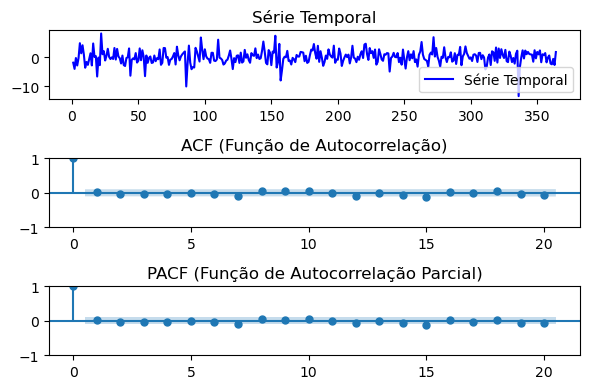

In [14]:
serie_dif1 = serie.diff().dropna()


fig, axes = plt.subplots(3, 1, figsize=(6, 4), sharex=False)


axes[0].plot(serie_dif1, label="Série Temporal", color="blue")
axes[0].set_title("Série Temporal")
axes[0].legend()


plot_acf(serie_dif1, ax=axes[1], lags=20, title="ACF (Função de Autocorrelação)")


plot_pacf(serie_dif1, ax=axes[2], lags=20, title="PACF (Função de Autocorrelação Parcial)", method='ywm')



plt.tight_layout()
plt.show()

In [15]:
result2 = adfuller(serie_dif1)

print('The test stastics:', result2[0])

print("p-value:",result2[1])

The test stastics: -18.62193049433529
p-value: 2.0609292021037016e-30


In [16]:
serie_dif1.mean()

0.038054936813186765

#### Transformação de Fourier

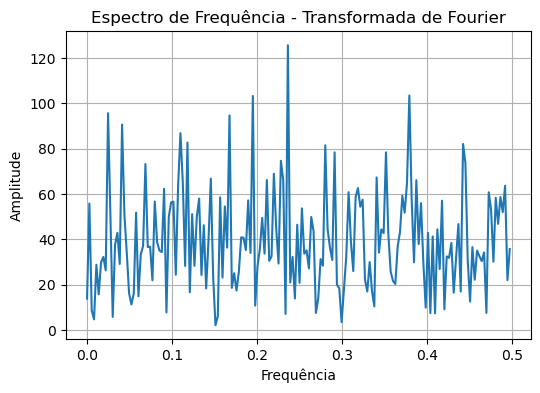

In [17]:
import numpy as np


fft_result = np.fft.fft(serie_dif1)
frequencias = np.fft.fftfreq(len(serie_dif1))


amplitude = np.abs(fft_result)


plt.figure(figsize=(6, 4))
plt.plot(frequencias[:len(frequencias)//2], amplitude[:len(amplitude)//2])
plt.title('Espectro de Frequência - Transformada de Fourier')
plt.xlabel('Frequência')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [18]:
#Observando que o grafico das funções de ACF e PACF, a correlação nao existe mesmo no lag1
#isso significa que nao existe um padrao linear a ser seguido (fazendo com que seja melhor o uso de modelos nao lineares)

In [19]:
#vou testar varios modelos arima(p,d,q) atraves do AIC e BIC e veremos o resultado

In [20]:
import statsmodels.api as sm
import pandas as pd 

# Lista para armazenar os valores de p, d, q, AIC e BIC
order_aic_bic = []

# Loop sobre os valores de p (autoregressão) de 0 a 2
for p in range(3):
    # Loop sobre os valores de d (diferenciação) de 0 a 2
    for d in range(2):
        # Loop sobre os valores de q (média móvel) de 0 a 2
        for q in range(3):
            try:
                # Criar e ajustar o modelo ARIMA (sem sazonalidade)
                # Parâmetro `order` define os valores de (p, d, q)
                model = sm.tsa.ARIMA(serie, order=(p, d, q))
                results = model.fit()
                
                # Armazena a ordem (p, d, q) e os valores de AIC e BIC no formato de tupla
                order_aic_bic.append((p, d, q, results.aic, results.bic))
            except:
                # Caso ocorra um erro ao ajustar o modelo, imprime (p, d, q) com valores nulos para AIC e BIC
                print(p, d, q, None, None)

# Criar um DataFrame com as ordens (p, d, q) e os valores de AIC e BIC
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'd', 'q', 'aic', 'bic'])

# Ordenar os resultados pelo menor AIC
print("Ordenado por AIC:")
print("\n")
print(order_df.sort_values('aic').reset_index(drop=True))

# Ordenar os resultados pelo menor BIC
print("Ordenado por BIC:")
print("\n")
print(order_df.sort_values('bic').reset_index(drop=True))


Ordenado por AIC:


    p  d  q          aic          bic
0   0  1  0  1665.142525  1669.039678
1   0  1  1  1666.974273  1674.768581
2   1  1  0  1666.989069  1674.783377
3   1  1  1  1667.101189  1678.792651
4   1  1  2  1667.967563  1683.556178
5   2  1  1  1667.982958  1683.571574
6   2  1  0  1668.242317  1679.933778
7   0  1  2  1668.249474  1679.940936
8   2  1  2  1669.964023  1689.449792
9   1  0  0  1675.042464  1686.742156
10  1  0  1  1676.780271  1692.379861
11  2  0  0  1676.800609  1692.400198
12  1  0  2  1678.242606  1697.742093
13  2  0  1  1678.612193  1698.111680
14  2  0  2  1678.857969  1702.257353
15  0  0  2  2334.569540  2350.169129
16  0  0  1  2626.810544  2638.510236
17  0  0  0  3055.529675  3063.329469
Ordenado por BIC:


    p  d  q          aic          bic
0   0  1  0  1665.142525  1669.039678
1   0  1  1  1666.974273  1674.768581
2   1  1  0  1666.989069  1674.783377
3   1  1  1  1667.101189  1678.792651
4   2  1  0  1668.242317  1679.933778
5   0  1  

In [21]:
#observa-se que o modelo não possui um padrao linear claro
#dado a natureza dos dados, o modelo é incompleto pois tambem precisa de fatores externos, mas vamos treinar msm assim:

In [22]:
# #vou estabelecer 80% dos dados para treinar e outros 20 para testa
tamanhoTreino = int(0.80 * len(serie))
serie_treino, serie_teste = serie[:tamanhoTreino], serie[tamanhoTreino:]


In [23]:
model = ARIMA(serie_treino, order=(0, 1, 1))
fitArima = model.fit()
print(fitArima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  292
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -664.502
Date:                Fri, 03 Jan 2025   AIC                           1333.004
Time:                        07:39:50   BIC                           1340.351
Sample:                             0   HQIC                          1335.947
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0283      0.062      0.459      0.646      -0.092       0.149
sigma2         5.6358      0.348     16.183      0.000       4.953       6.318
Ljung-Box (L1) (Q):                   0.00   Jarque-

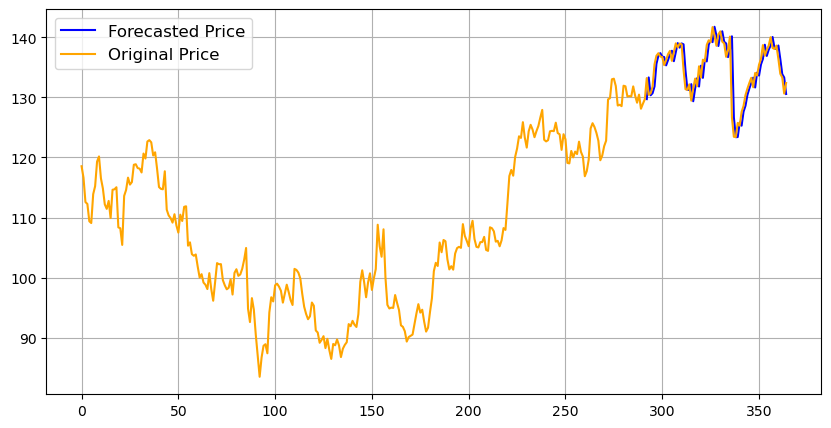

In [24]:
#previsao arima com retroalimentação:
import numpy as np
import matplotlib.pyplot as plt

#one step ahead no conjunto de teste:


history = list(serie_treino)

#so p n resetar o indice
serie_teste2 = serie_teste.reset_index(drop="True")


predictions = []

# Loop para previsões one-step-ahead
for t in range(len(serie_teste)):
    model = ARIMA(history, order=(0, 1, 1))
    fit = model.fit()
    forecast = fit.forecast(steps=1)[0]  
    predictions.append(forecast)
    history.append(serie_teste2[t])  


df_pred = pd.DataFrame(predictions, columns=['predictions'], index=serie_teste.index)

df_pred.index = np.array(df_pred.index)  


plt.figure(figsize=(10, 5)) 


plt.plot(df_pred.index, df_pred['predictions'], label='Forecasted Price', color='blue')
plt.plot(serie.index, serie, label='Original Price', color='orange')


plt.legend(fontsize=12)


plt.grid(True)  
plt.show()

In [25]:
mae_arima = mean_absolute_error(serie_teste, df_pred)
mse_arima = mean_squared_error(serie_teste, df_pred)
print(f"MAE (arima): {mae_arima}")
print(f"MSE (arima): {mse_arima}")

MAE (arima): 1.6712251066454127
MSE (arima): 5.708401302979909


### LSTM:

In [26]:
#vamos preparar os dados, e separar entre treino e teste
#nesse caso tambem precisamos preparar o input e o output
#nesse caso o input sao sequencias
#e o output é o valor seguinte a cada sequencia
#vamos usar um curto prazo de 10 dias
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))

# Normalizar os dados
serie_normalizada = scaler.fit_transform(pd.DataFrame(serie))

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(serie_normalizada, seq_length)
#X: é uma sequencia de 5 entradas
#Y: é o resultado da sequencia

In [27]:
tamanhoTreino = int(0.80 * len(serie))
X_train, X_teste = X[:tamanhoTreino], X[tamanhoTreino:]
y_train, y_teste = y[:tamanhoTreino], y[tamanhoTreino:]

In [28]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense, Input

class LSTMModel(Model):
    def __init__(self, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Criando camadas LSTM empilhadas
        self.lstm_layers = [LSTM(hidden_size, return_sequences=True) for _ in range(num_layers - 1)]
        self.lstm_layers.append(LSTM(hidden_size, return_sequences=False))  # Última camada sem `return_sequences`
        
        # Camada totalmente conectada (fully connected)
        self.fc = Dense(output_size)

    def call(self, x):
        # Passando pelas camadas LSTM
        for layer in self.lstm_layers:
            x = layer(x)
        
        # Camada de saída
        output = self.fc(x)
        return output



In [29]:
# Modelo LSTM (usando a classe definida anteriormente)
model = LSTMModel(hidden_size=64, num_layers=2, output_size=1)

# Compilar o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse')

# Treinamento automático com model.fit()
num_epochs = 100
model.fit(X_train, y_train, epochs=num_epochs)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1807
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0267
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0188 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0142
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0062
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


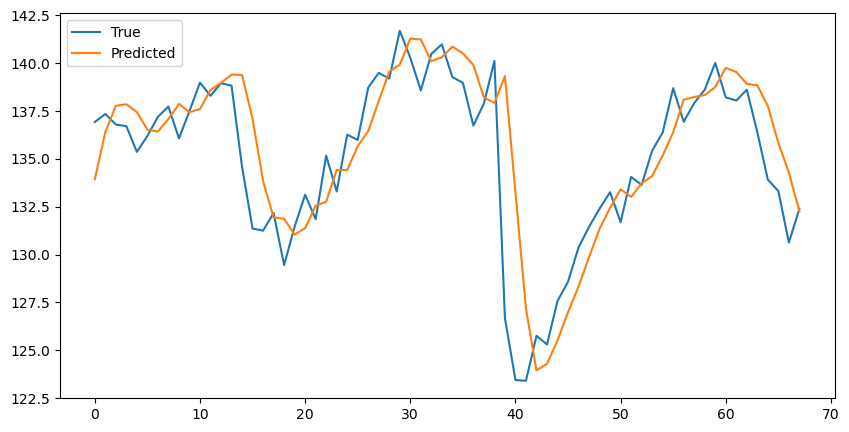

In [30]:
#previsao one-step-ahead: com retro-alimentação
predictions = model.predict(X_teste)  # Previsões do modelo

# Reverter transformações (se houver normalização/escala)
predictions = scaler.inverse_transform(predictions)  # Inversão do scaler nas previsões
y_teste = scaler.inverse_transform(y_teste.reshape(-1, 1))  # Inversão do scaler nos valores verdadeiros


plt.figure(figsize=(10, 5))
plt.plot(y_teste, label='True')          # Valores reais
plt.plot(predictions, label='Predicted')  # Previsões
plt.legend()
plt.show()


In [31]:
mae_lstm = mean_absolute_error(y_teste, predictions)
mse_lstm = mean_squared_error(y_teste, predictions)
print(f"MAE (lstm): {mae_lstm}")
print(f"MSE (lstm): {mse_lstm}")

MAE (lstm): 1.8037391124842013
MSE (lstm): 7.296551245477571


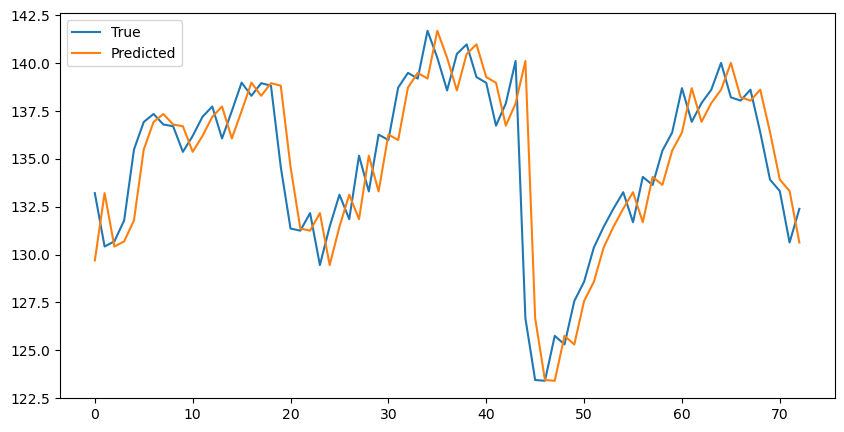

In [32]:

# Modelo Naive (one-step ahead)
naive_predictions = [serie_treino.iloc[-1]]  # Primeira previsão é o último valor do treino
for i in range(1, len(serie_teste)):
    naive_predictions.append(serie_teste.iloc[i-1])  # Valor do teste anterior prevê o próximo

plt.figure(figsize=(10, 5))
plt.plot(serie_teste.reset_index(drop="True"), label='True')# Valores reais
plt.plot(naive_predictions, label='Predicted')  # Previsões
plt.legend()
plt.show()


In [33]:
mae_naive = mean_absolute_error(serie_teste, naive_predictions)
mse_naive = mean_squared_error(serie_teste, naive_predictions)
print(f"MAE (Naive): {mae_naive}")
print(f"MSE (Naive): {mse_naive}")

MAE (Naive): 1.6682187808219169
MSE (Naive): 5.677334291267289


#### usando o modelo naive como parametro, percebemos que tanto o arima quando a lstm nao tiveram bons resultados

In [55]:
from neuralprophet import NeuralProphet

In [61]:
#hiperparametros neutalprophet:

#n_changepoints = por default é igual a 10, é importante nos pontos de mudança
#yearly_seasonality=
#weekly_seasonality=
#daily_seasonality=
#n_lags=10 (autoregressao)

m = NeuralProphet(
    n_changepoints=20,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
     n_lags=5,
)
dataPropnet = data[["Date", "Close"]]
dataPropnet.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
dataPropnet

,ds,y
0,2004-08-19,2.499133
1,2004-08-20,2.697639
2,2004-08-23,2.724787
3,2004-08-24,2.611960
4,2004-08-25,2.640104
...,...,...
4853,2023-11-29,136.399994
4854,2023-11-30,133.919998
4855,2023-12-01,133.320007
4856,2023-12-04,130.630005


In [62]:
metrics = m.fit(dataPropnet)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.398% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.data.processing._handle_missing_data) - Added 176 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 176 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 176 NaN values in column y were auto-imputed.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 70


Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (79) is too small than the required number                     for the learning rate finder (242). The results might not be optimal.


Finding best initial lr:   0%|          | 0/242 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

In [63]:
forecast = m.predict(dataPropnet)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.398% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.398% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.data.processing._handle_missing_data) - Added 176 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 176 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 176 NaN values in column y were auto-imputed.


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [64]:
m.plot(forecast)


ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.


In [65]:
forecast

,ds,y,yhat1,ar1,trend
0,2004-08-19,2.499133,NaN,NaN,NaN
1,2004-08-20,2.697639,NaN,NaN,NaN
2,2004-08-23,2.724787,NaN,NaN,NaN
3,2004-08-24,2.611960,NaN,NaN,NaN
4,2004-08-25,2.640104,NaN,NaN,NaN
...,...,...,...,...,...
5029,2023-11-29,136.399994,138.468307,-217.411057,355.879364
5030,2023-11-30,133.919998,136.593765,-219.301178,355.894928
5031,2023-12-01,133.320007,134.839722,-221.070770,355.910492
5032,2023-12-04,130.630005,133.391251,-222.565903,355.957153


In [66]:
forecast = forecast.dropna(subset=['yhat1'])
mse = mean_squared_error(forecast['y'], forecast['yhat1'])
mae = mean_absolute_error(forecast['y'], forecast['yhat1'])

print(f"MAE(neuralpropnet): {mae}")
print(f"MSE(neuralpropnet): {mse}")


MAE(neuralpropnet): 0.5563313881476206
MSE(neuralpropnet): 1.1952234156342567


#### o modelo hibrido neuralprophet bateu todos os outros modelos com poucos ajustes de hiperparametros